# ДЗ 2. CNN. Детектирование

- Вам нужно будет загрузить и оформить датасет котиков, собак https://www.kaggle.com/andrewmvd/dog-and-cat-detection  
- *Нужно будет произвести аугментацию данных  
- Затем обучить нейронную сеть на получившемся датасете  

## Библиотеки и скрипты

In [1]:
import numpy as np
import pandas as pd
import os
import cv2

import torch
from torch import tensor
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

from sklearn.model_selection import train_test_split

from pathlib import Path
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [2]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(bb, x):
    """Создаем маску для bounding box'a такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Конвертируем маску Y в bounding box'a, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols) == 0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Генерируем массив bounding box'a из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])


def resize_image_bb(read_path, write_path, bb, sz):
    """Ресайзим изображение и его bounding box и записываем изображение в новый путь"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

def crop(im, r, c, target_r, target_c): 
    """Вырезаем кусок с изображения"""
    return im[r:r+target_r, c:c+target_c]

def center_crop(x, r_pix=8):
    """Центральное вырезание """
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT):
    """ Поворачиваем наше изображение"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M, (c, r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im, M, (c, r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix * c/r)
    rand_r = np.random.uniform(0, 1)
    rand_c = np.random.uniform(0, 1)
    start_r = np.floor(2 * rand_r * r_pix).astype(int)
    start_c = np.floor(2 * rand_c * c_pix).astype(int)
    xx = crop(x, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    YY = crop(Y, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    return xx, YY

def transformsXY(path, bb, is_transforms):
    """Трансформируем нашу картинку"""
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
    Y = create_mask(bb, x)
    if is_transforms:
        rdeg = (np.random.random()-.50) * 20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

## Загрузка и обзор данных

In [3]:
# Зададаем пути
DATA_FOLDER_PATH = './data/cats_dogs'
IMAGES_PATH = os.path.join(DATA_FOLDER_PATH, 'images')
ANNOTATION_PATH = os.path.join(DATA_FOLDER_PATH, 'annotations')

In [4]:
def generate_train_df(anno_path):
    annotations = [os.path.join(ANNOTATION_PATH, filename) for filename in os.listdir(anno_path)]
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(IMAGES_PATH) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [5]:
df_train = generate_train_df(ANNOTATION_PATH)
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,data\cats_dogs\images\Cats_Test0.png,233,350,cat,83,29,197,142
1,data\cats_dogs\images\Cats_Test1.png,500,500,dog,128,22,240,222
2,data\cats_dogs\images\Cats_Test10.png,500,375,dog,157,56,264,116
3,data\cats_dogs\images\Cats_Test100.png,500,375,cat,142,145,206,209
4,data\cats_dogs\images\Cats_Test101.png,500,375,cat,134,79,297,234
...,...,...,...,...,...,...,...,...
496,data\cats_dogs\images\Cats_Test95.png,500,375,dog,170,180,280,291
497,data\cats_dogs\images\Cats_Test96.png,500,375,cat,220,107,309,209
498,data\cats_dogs\images\Cats_Test97.png,373,451,dog,18,30,323,338
499,data\cats_dogs\images\Cats_Test98.png,300,225,dog,137,26,219,111


In [6]:
# Целевой класс
df_train['class'].value_counts()

dog    338
cat    163
Name: class, dtype: int64

## Предобработка данных

In [7]:
# Кодирование категориальной переменной
class_dict = {'cat': 0, 'dog': 1}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])
df_train.head(2)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,data\cats_dogs\images\Cats_Test0.png,233,350,0,83,29,197,142
1,data\cats_dogs\images\Cats_Test1.png,500,500,1,128,22,240,222


In [8]:
# Размер картинки
IM_SIZE = 300

new_paths = []
new_bbs = []
train_path_resized = Path('./data/cats_dogs/images_resized')
Path.mkdir(train_path_resized, exist_ok=True)

for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values), IM_SIZE)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
    
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,data\cats_dogs\images\Cats_Test0.png,233,350,0,83,29,197,142,data\cats_dogs\images_resized\Cats_Test0.png,"[24.0, 106.0, 121.0, 253.0]"
1,data\cats_dogs\images\Cats_Test1.png,500,500,1,128,22,240,222,data\cats_dogs\images_resized\Cats_Test1.png,"[13.0, 77.0, 132.0, 143.0]"
2,data\cats_dogs\images\Cats_Test10.png,500,375,1,157,56,264,116,data\cats_dogs\images_resized\Cats_Test10.png,"[44.0, 94.0, 92.0, 158.0]"
3,data\cats_dogs\images\Cats_Test100.png,500,375,0,142,145,206,209,data\cats_dogs\images_resized\Cats_Test100.png,"[116.0, 85.0, 167.0, 123.0]"
4,data\cats_dogs\images\Cats_Test101.png,500,375,0,134,79,297,234,data\cats_dogs\images_resized\Cats_Test101.png,"[63.0, 80.0, 187.0, 177.0]"


(350, 233, 3) [ 29  83 142 197]


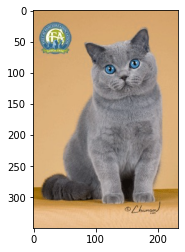

In [9]:
# Посмотрим пример
IMAGE_INDEX = 0

im = cv2.imread(str(df_train.values[IMAGE_INDEX][0]))
bb = create_bb_array(df_train.values[IMAGE_INDEX])
print(im.shape, bb)

Y = create_mask(bb, im)
mask_to_bb(Y)
plt.imshow(im)

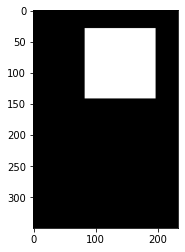

In [10]:
plt.imshow(Y, cmap='gray')

data\cats_dogs\images_resized\Cats_Test139.png


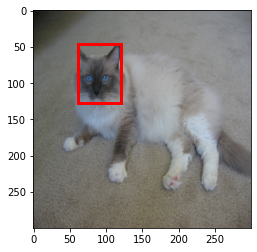

In [11]:
number = 45
im = cv2.imread(str(df_train['new_path'].values[number]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train['new_bb'].values[number])

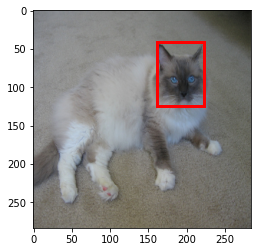

In [12]:
im, bb = transformsXY(str(df_train['new_path'].values[number]),
                      df_train['new_bb'].values[number],
                      is_transforms=True)
show_corner_bb(im, bb)

## Тестовый и валидационный датасеты

In [13]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((400, 2), (101, 2))

In [14]:
def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0]) / imagenet_stats[1]


class AnimalsDataset(Dataset):
    def __init__(self, paths, bb, y, is_transforms=False):
        self.is_transforms = is_transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.is_transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [15]:
train_ds = AnimalsDataset(X_train['new_path'], X_train['new_bb'], y_train, is_transforms=True)
valid_ds = AnimalsDataset(X_val['new_path'], X_val['new_bb'], y_val)

In [16]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

## resNet-34

In [17]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [18]:
resnet = models.resnet34(pretrained=True)
list(resnet.children())[:1]

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace=True)
   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): ReLU(inplace=True)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (6): ReLU(inplace=True)
   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): ReLU(inplace=True)
   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace=True)
   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (13): ReLU(inplace=True)
   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (15): ReLU(inplace=True)
   (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (17): ReLU(inplace=T

In [19]:
model = BB_model()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.006)
epochs = 10
model

BB_model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [20]:
def train():
    for i in range(epochs):

        model.train()
        total = 0
        sum_loss = 0

        for x, y_class, y_bb in train_dl:
            y_class = tensor(np.array(list(y_class)))
            len_batch = y_class.shape[0]
            x = x.float()
            y_bb = y_bb.float()
            out_class, out_bb = model(x)
            
            # losses
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            
            loss = loss_class + loss_bb
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total += len_batch
            sum_loss += loss.item()
        
        train_loss = sum_loss / total

        # Eval
        model.eval()
        val_total = 0
        val_sum_loss = 0
        correct = 0

        for x, y_class, y_bb in valid_dl:
            y_class = tensor(np.array(list(y_class)))
            len_batch = y_class.shape[0]
            x = x.float()
            y_bb = y_bb.float()
            
            out_class, out_bb = model(x)
            
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            loss = loss_class + loss_bb
            
            _, pred = torch.max(out_class, 1)
            correct += (pred == y_class).sum().item()
            
            val_sum_loss += loss.item()
            val_total += len_batch
            
        val_loss = val_sum_loss / val_total
        val_acc = correct / val_total

        print(f"Epoch [{i+1}/{epochs}]. train_loss {train_loss:.3f} val_loss {val_loss:.3f} val_acc {val_acc:.3f}")

In [21]:
train()

c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/10]. train_loss 490.461 val_loss 125011.803 val_acc 0.059
Epoch [2/10]. train_loss 397.885 val_loss 488.267 val_acc 0.455
Epoch [3/10]. train_loss 238.262 val_loss 974.056 val_acc 0.119
Epoch [4/10]. train_loss 147.116 val_loss 218.556 val_acc 0.604
Epoch [5/10]. train_loss 141.032 val_loss 145.765 val_acc 0.644
Epoch [6/10]. train_loss 141.129 val_loss 166.841 val_acc 0.644
Epoch [7/10]. train_loss 140.578 val_loss 144.785 val_acc 0.594
Epoch [8/10]. train_loss 138.968 val_loss 147.971 val_acc 0.604
Epoch [9/10]. train_loss 140.834 val_loss 146.364 val_acc 0.673
Epoch [10/10]. train_loss 139.138 val_loss 147.558 val_acc 0.653


In [22]:
# Сохраняем модель
torch.save(model.state_dict(), './data/cats_dogs/model')

## Делаем предсказание

In [84]:
# Изменяем размер
im = read_image('./data/cats_dogs/images_resized/Cats_Test20.png')
Path.mkdir(Path('./data/cats_dogs/df_valid'), exist_ok=True)
cv2.imwrite('./data/cats_dogs/df_valid/Cats_Test0.png', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [85]:
# test Dataset
df_valid = AnimalsDataset(
    pd.DataFrame([{'path':'./data/cats_dogs/df_valid/Cats_Test0.png'}])['path'],
    pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],
    pd.DataFrame([{'y':[0]}])['y']
)
x, y_class, y_bb = df_valid[0]

xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 284])

In [86]:
# prediction
out_class, out_bb = model(xx)
out_class, out_bb

(tensor([[ 1.1908,  2.3691, -4.9300, -5.1703]], grad_fn=<AddmmBackward>),
 tensor([[ 20.7985,  70.8085, 171.1921, 215.4428]], grad_fn=<AddmmBackward>))

In [87]:
# predicted class
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([2.3691], grad_fn=<MaxBackward0>),
indices=tensor([1]))

In [88]:
class_dict

{'cat': 0, 'dog': 1}

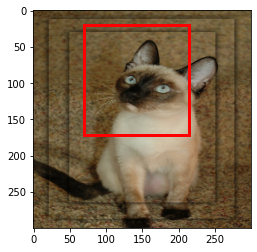

In [89]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])